# Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix
import pickle
import cv2 as cv
# import time

# Defining paths

In [2]:
# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_02_IL'
# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_01_CA1
cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211206/mouse_02_IL'
path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')

# Parameters

In [3]:
dict_meta = {'framerate_inscopix': 20,
             'framerate_behavior': 15,
             'frame_count': np.array([3641,3773,3800,3691,3867,4254,3945,3793,3946,3647,3721,3682]),
             'discard_sessions': np.array([8]),
             'dict_env': {'t_maze': [0,4,6,9],
                          'y_maze': [1,3,7,8],
                          'open_field': [2,5,10]}
            }



# dict_meta = {'framerate_inscopix': 10,
#              'framerate_behavior': 15,
#              'frame_count': np.array([2102,2054,1896,2011,1948,1859,1852,1838,1870,1945,1891,1897]),
#              'discard_sessions': np.array([]),
#              'dict_env': {'t_maze': [1,3,7,9],
#                           'y_maze': [0,4,6,10],
#                           'open_field': [2,5,8,11]}
#             }

# dict_meta = {'framerate_inscopix': 20,
#              'framerate_behavior': 15,
#              'frame_count': np.array([4015, 3709, 3872, 3715, 3737, 3752, 4344, 3698, 4628, 3801, 3770, 3774]),
#              'discard_sessions': np.array([8,9]),
#              'dict_env': {'t_maze': [0, 3, 6],
#                           'y_maze': [1, 4, 7, 8],
#                           'open_field': [2, 5, 9]}
#             }



# Loading files

## Table frames

In [4]:
df_frames = pd.read_csv(path_table, index_col = 0)
df_frames['session'] = ''
for i,r in df_frames.iterrows():
    df_frames.loc[i, 'session'] = df_frames.loc[i, 'file'].split('.')[0]

## Matrix spikes

### Loading

In [5]:
with h5py.File(path_mat_spikes, 'r') as f:
    mat_spikes = csr_matrix((f['finalSpikesMat']['data'], f['finalSpikesMat']['ir'], f['finalSpikesMat']['jc']))
    mat_spikes = mat_spikes.toarray()

### Plotting first neurons for sanity check

(45760, 308)


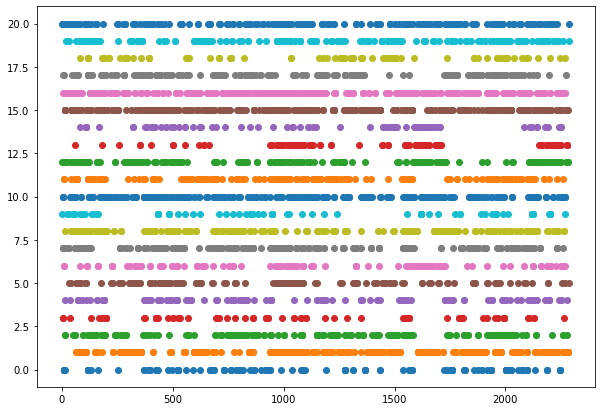

In [6]:
plt.figure(figsize = (10,7))
for (i,r) in enumerate(mat_spikes.T):
    if i > 20:
        break
    spikes = np.where(r)[0]
    plt.scatter(spikes/dict_meta['framerate_inscopix'], [i] * len(spikes))
print(mat_spikes.shape)

### Getting recording ratios

In [7]:
meta_spikes = pd.DataFrame(index = range(mat_spikes.shape[0]), columns = ['session', 'frame_number', 'frame_ratio'])

cursor = 0
cur_session = -1
for i, fcount in enumerate(dict_meta['frame_count']):
    
    end_cursor = cursor + fcount - 1
    if i in dict_meta['discard_sessions']:
        session_label = 'discarded' 
    else:
        cur_session += 1
        session_label = df_frames.loc[cur_session, 'file'].split('.')[0]
        
    meta_spikes.loc[cursor:end_cursor, 'session'] = session_label
    meta_spikes.loc[cursor:end_cursor, 'frame_number'] = range(fcount)
    meta_spikes.loc[cursor:end_cursor, 'recording_ratio'] = meta_spikes.loc[cursor:end_cursor, 'frame_number'] / (fcount - 1)
    cursor += fcount

from collections import Counter
print(Counter(meta_spikes['session']))
meta_spikes

Counter({'WIN_20211206_18_31_05_Pro': 4254, 'discarded': 3946, 'WIN_20211206_18_38_09_Pro': 3945, 'WIN_20211206_18_26_41_Pro': 3867, 'WIN_20211206_18_17_38_Pro': 3800, 'WIN_20211206_18_41_58_Pro': 3793, 'WIN_20211206_18_13_22_Pro': 3773, 'WIN_20211206_18_53_07_Pro': 3721, 'WIN_20211206_18_22_29_Pro': 3691, 'WIN_20211206_18_56_49_Pro': 3682, 'WIN_20211206_18_49_29_Pro': 3647, 'WIN_20211206_18_09_25_Pro': 3641})


,session,frame_number,frame_ratio,recording_ratio
0,WIN_20211206_18_09_25_Pro,0,NaN,0.0
1,WIN_20211206_18_09_25_Pro,1,NaN,0.000275
2,WIN_20211206_18_09_25_Pro,2,NaN,0.000549
3,WIN_20211206_18_09_25_Pro,3,NaN,0.000824
4,WIN_20211206_18_09_25_Pro,4,NaN,0.001099
...,...,...,...,...
45755,WIN_20211206_18_56_49_Pro,3677,NaN,0.998913
45756,WIN_20211206_18_56_49_Pro,3678,NaN,0.999185
45757,WIN_20211206_18_56_49_Pro,3679,NaN,0.999457
45758,WIN_20211206_18_56_49_Pro,3680,NaN,0.999728


## Deep lab cut

### Loading

In [8]:
dlc_files = np.array(os.listdir(os.path.join(cur_dir, 'dlc')))
dlc_files = dlc_files[[s.endswith('filtered.csv') for s in dlc_files]]
if len(dlc_files) != 1:
    sys.exit('There should be only one DLC file, this is not the case')
dlc_files = dlc_files[0]
df_dlc = pd.read_csv(os.path.join(cur_dir, 'dlc', dlc_files), skiprows = 2, index_col = 0)
df_dlc['xc'] = 0
df_dlc['yc'] = 0
for i,r in df_dlc.iterrows():
    df_dlc.loc[i, 'xc'] = np.mean([r['x'], r['x.1'], r['x.2'], r['x.3']])
    df_dlc.loc[i, 'yc'] = np.mean([r['y'], r['y.1'], r['y.2'], r['y.3']])
df_dlc

,x,y,likelihood,x.1,y.1,likelihood.1,x.2,y.2,likelihood.2,x.3,y.3,likelihood.3,xc,yc
coords,,,,,,,,,,,,,,
0,486.690063,248.279572,0.998769,476.771332,255.294785,0.999867,486.133331,259.977142,0.999813,475.401093,269.376556,0.998648,481.248955,258.232014
1,486.723053,248.385132,0.998724,476.848694,255.349609,0.999823,486.716858,260.064880,0.999822,475.529663,269.376556,0.998506,481.454567,258.294044
2,486.856232,248.385132,0.998716,476.921814,255.349609,0.999765,486.756073,260.064880,0.999797,475.532318,269.376556,0.998376,481.516609,258.294044
3,487.311127,248.336700,0.998592,477.296997,255.294785,0.999745,487.032623,259.977142,0.999746,475.690826,269.376556,0.998780,481.832893,258.246296
4,487.576202,248.305374,0.998032,477.639557,255.273773,0.999692,487.222809,259.863983,0.999660,476.061981,269.142822,0.998868,482.125137,258.146488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31305,436.854645,94.305382,0.999652,431.397797,80.280922,0.999182,421.764801,92.389885,0.999442,416.294525,80.454918,0.999709,426.577942,86.857777
31306,436.855713,94.305382,0.999607,430.798798,80.126244,0.999302,421.764801,92.196205,0.999521,415.823853,80.454918,0.999565,426.310791,86.770687
31307,437.154144,90.382782,0.999201,430.567413,78.342728,0.999120,422.785522,92.498787,0.999292,414.466492,80.994751,0.999264,426.243393,85.554762


### Getting recoridng and ts

In [9]:
df_dlc['session'] = ''
df_dlc['frame_number'] = 0
df_dlc['recording_ratio'] = 0
cursor = 0
for i,r in df_frames.iterrows():
    end_cursor = cursor+r['end_frame']-r['start_frame'] 
    df_dlc.loc[cursor:end_cursor, 'session'] = r['file'].split('.')[0]
    df_dlc.loc[cursor:end_cursor, 'frame_number'] = range(r['end_frame'] - r['start_frame'] + 1)
    df_dlc.loc[cursor:end_cursor, 'recording_ratio'] = df_dlc.loc[cursor:end_cursor, 'frame_number'] / (r['end_frame'] - r['start_frame'])
    cursor += (r['end_frame'] - r['start_frame'] + 1)

### Matching spikes to behavioral frames

In [10]:
meta_spikes['behavioral_frame'] = 0
meta_spikes['x'] = 0
meta_spikes['y'] = 0

for i,r in meta_spikes.iterrows():
    cur_session = r['session']
    if r['session'] == 'discarded':
        continue
    sub_df_dlc = df_dlc.query('session == @cur_session')    
    meta_spikes.loc[i,'behavioral_frame'] = sub_df_dlc.index[np.argmin(np.abs(r['recording_ratio'] - sub_df_dlc['recording_ratio']))]
    meta_spikes.loc[i,'x'] = df_dlc.loc[meta_spikes.loc[i, 'behavioral_frame']]['xc']
    meta_spikes.loc[i,'y'] = df_dlc.loc[meta_spikes.loc[i, 'behavioral_frame']]['yc']
    if i%1000 == 0:
        print('%05d/%d' % (i, meta_spikes.shape[0]))

00000/45760
01000/45760
02000/45760
03000/45760
04000/45760
05000/45760
06000/45760
07000/45760
08000/45760
09000/45760
10000/45760
11000/45760
12000/45760
13000/45760
14000/45760
15000/45760
16000/45760
17000/45760
18000/45760
19000/45760
20000/45760
21000/45760
22000/45760
23000/45760
24000/45760
25000/45760
26000/45760
27000/45760
28000/45760
29000/45760
30000/45760
35000/45760
36000/45760
37000/45760
38000/45760
39000/45760
40000/45760
41000/45760
42000/45760
43000/45760
44000/45760
45000/45760


In [11]:
meta_spikes

,session,frame_number,frame_ratio,recording_ratio,behavioral_frame,x,y
0,WIN_20211206_18_09_25_Pro,0,NaN,0.0,0,481.248955,258.232014
1,WIN_20211206_18_09_25_Pro,1,NaN,0.000275,1,481.454567,258.294044
2,WIN_20211206_18_09_25_Pro,2,NaN,0.000549,1,481.454567,258.294044
3,WIN_20211206_18_09_25_Pro,3,NaN,0.000824,2,481.516609,258.294044
4,WIN_20211206_18_09_25_Pro,4,NaN,0.001099,3,481.832893,258.246296
...,...,...,...,...,...,...,...
45755,WIN_20211206_18_56_49_Pro,3677,NaN,0.998913,31306,426.310791,86.770687
45756,WIN_20211206_18_56_49_Pro,3678,NaN,0.999185,31307,426.243393,85.554762
45757,WIN_20211206_18_56_49_Pro,3679,NaN,0.999457,31308,425.463799,85.178295
45758,WIN_20211206_18_56_49_Pro,3680,NaN,0.999728,31308,425.463799,85.178295


### Checking offset between recordings

In [12]:
duration_inscopix = (np.sum(dict_meta['frame_count']) - np.sum([dict_meta['frame_count'][idx] for idx in dict_meta['discard_sessions']])) / dict_meta['framerate_inscopix']
duration_behavior = df_dlc.shape[0] / dict_meta['framerate_behavior']
time_diff = np.abs(duration_inscopix - duration_behavior)
avg_shit_session = time_diff / len(pd.unique(df_dlc['session']))
print('Duration behavior: %.2fs\nDuration inscopix: %.2fs\nTime difference: %.2fs\nAverage shift per session: %.2fs' % (duration_behavior, duration_inscopix, time_diff, avg_shit_session))

Duration behavior: 2087.33s
Duration inscopix: 2090.70s
Time difference: 3.37s
Average shift per session: 0.31s


# Saving

In [13]:
os.makedirs(os.path.join(cur_dir, 'pickle'), exist_ok=False)
with open(os.path.join(cur_dir, 'pickle', 'meta_spikes.pck'), 'wb') as f:
    pickle.dump(meta_spikes, f)
with open(os.path.join(cur_dir, 'pickle', 'df_dlc.pck'), 'wb') as f:
    pickle.dump(df_dlc, f)
with open(os.path.join(cur_dir, 'pickle', 'df_frames.pck'), 'wb') as f:
    pickle.dump(df_frames, f)    
with open(os.path.join(cur_dir, 'pickle', 'mat_spikes.pck'), 'wb') as f:
    pickle.dump(mat_spikes, f)  
with open(os.path.join(cur_dir, 'pickle', 'dict_meta.pck'), 'wb') as f:
    pickle.dump(dict_meta, f)